In [ ]:
!pip install ultralytics
!pip install git+https://github.com/facebookresearch/segment-anything.git
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 21.3 MB/s eta 0:00:00
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-pkn5rhw_
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-pkn5rhw_
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=8f810730f48c8ef1cd085b3eef17baac1fc03459064b405525086a692eb941b9
  Stored in directory: /tmp/pip-ephem-wheel-cache-pe_ylo0_/wheels/29/82/ff/04e2be9805a1cb48bec0b85b5a6da6b63f647645750a0e42d4
Successfully built segment_anything
--2025-12-14 20:50:18--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 99.84.41.79, 99.84.41.80, 99.84.41.33, .

In [ ]:
import pandas as pd
import os, cv2, csv, uuid, numpy as np
from pathlib import Path
from ultralytics import YOLO
from PIL import Image
import torch
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor
import random
import seaborn as sns

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# each user edits ONLY this line to their own path
PROJECT_ROOT = Path("/content/drive/MyDrive/Machine learning/fishfoto")
#PROJECT_ROOT = Path("/content/drive/MyDrive/Colab Notebooks/Masinõpe/ML_Project/fishfoto")

EXTRACTION_MODEL_WEIGHTS = PROJECT_ROOT / "models/extraction_model/yolo_boxes_BIAS/fish_seg_final_results/weights/best.pt"
CLASSIFICATION_MODEL_WEIGHTS = PROJECT_ROOT / "models/classification_model/runs/YOLO8m/weights/best.pt"

## Models

In [ ]:
extraction_model = YOLO(EXTRACTION_MODEL_WEIGHTS)
classification_model = YOLO(CLASSIFICATION_MODEL_WEIGHTS)

# GPU needed
sam = sam_model_registry["vit_h"](checkpoint="sam_vit_h_4b8939.pth")
sam.to("cuda")

extractor = SamPredictor(sam)

## Extraction

In [ ]:
# UTILITY: Save transparent PNG
def save_masked_crop(orig_img_rgb, mask, out_path):
    ys, xs = np.where(mask)
    if len(ys) == 0:
        return False

    y0, y1 = ys.min(), ys.max()
    x0, x1 = xs.min(), xs.max()

    crop = orig_img_rgb[y0:y1+1, x0:x1+1]
    m = mask[y0:y1+1, x0:x1+1]

    # Build white background / use this
    result = np.full_like(crop, 255)
    result[m] = crop[m]

    # Build RGBA with transparent background / don't use
    #rgba = np.dstack([crop, (m * 255).astype(np.uint8)])
    #Image.fromarray(rgba).save(out_path)

    Image.fromarray(result).save(out_path)

    return True


def rotate_if_vertical(img_rgb):
    H, W = img_rgb.shape[:2]
    if H > W:
        img_rgb = cv2.rotate(img_rgb, cv2.ROTATE_90_COUNTERCLOCKWISE)
        return img_rgb
    return img_rgb


def yolo_predict_rotated(extraction_model, processed_rgb):
    """
    Saves processed_rgb temporarily to disk, passes it to YOLO,
    deletes the file, returns YOLO results.
    """
    # Generate a random filename to avoid conflicts
    tmp_filename = f"_tmp_rotated_input_{uuid.uuid4().hex}.png"
    tmp_path = str(PROJECT_ROOT / tmp_filename)

    # Save the rotated image to disk (BGR for OpenCV)
    processed_bgr = cv2.cvtColor(processed_rgb, cv2.COLOR_RGB2BGR)
    cv2.imwrite(tmp_path, processed_bgr)

    # Run YOLO only horizontal images, since it was trained that way
    preds = extraction_model.predict(
        source=tmp_path,
        imgsz=1024,
        conf=0.25,
        verbose=False
    )[0]

    # REMOVE the temporary file
    os.remove(tmp_path)

    return preds

In [ ]:
TEST_CONTAINERS = PROJECT_ROOT / "data/fishfoto_data_raw/kilu_raim_train_test_split/test"

OUT_TEST_DATASET = PROJECT_ROOT / "pipeline/dataset_extracted"
OUT_TEST_DATASET.mkdir(parents=True, exist_ok=True)

IMAGES_OUT = OUT_TEST_DATASET / "images"
IMAGES_OUT.mkdir(exist_ok=True)

CSV_PATH = OUT_TEST_DATASET / "labels.csv"

MIN_AREA = 10_000

# -------- MAIN EXTRACTION LOOP --------
records = []
counter = 1

for class_name in ["kilu", "raim"]:

    container_folder = TEST_CONTAINERS / class_name
    image_paths = sorted(container_folder.glob("*.jpg")) + sorted(container_folder.glob("*.png"))

    print(f"\nProcessing {len(image_paths)} test images for class '{class_name}'")

    for img_path in image_paths:

        # Load image
        orig_bgr = cv2.imread(str(img_path))
        orig_rgb = cv2.cvtColor(orig_bgr, cv2.COLOR_BGR2RGB)

        # Rotate if necessary
        processed_rgb = rotate_if_vertical(orig_rgb)

        # YOLO prediction on rotated image
        preds = yolo_predict_rotated(extraction_model, processed_rgb)

        # Image size after rotation
        orig_h, orig_w = processed_rgb.shape[:2]

        # Scaling YOLO → rotated/original
        yolo_h, yolo_w = preds.boxes.orig_shape
        scale_x = orig_w / yolo_w
        scale_y = orig_h / yolo_h

        # SAM receives the SAME rotated image
        extractor.set_image(processed_rgb)

        # ---- YOLO → SAM → Save ----
        for (x1, y1, x2, y2) in preds.boxes.xyxy.cpu().numpy():

            # Rescale boxes
            x1_o = int(x1 * scale_x)
            y1_o = int(y1 * scale_y)
            x2_o = int(x2 * scale_x)
            y2_o = int(y2 * scale_y)

            x1_o = max(0, min(orig_w - 1, x1_o))
            y1_o = max(0, min(orig_h - 1, y1_o))
            x2_o = max(0, min(orig_w - 1, x2_o))
            y2_o = max(0, min(orig_h - 1, y2_o))

            cx_o = (x1_o + x2_o) // 2
            cy_o = (y1_o + y2_o) // 2

            # SAM segmentation
            masks, _, _ = extractor.predict(
                point_coords=np.array([[cx_o, cy_o]]),
                point_labels=np.array([1]),
                box=np.array([x1_o, y1_o, x2_o, y2_o]),
                multimask_output=False
            )

            mask = masks[0]

            if mask.sum() < MIN_AREA:
                continue

            out_name = f"{counter:06d}.png"
            out_path = IMAGES_OUT / out_name

            # Save using rotated image
            ok = save_masked_crop(processed_rgb, mask, out_path)
            if ok:
                records.append([out_name, class_name])
                counter += 1


# ---------- Write CSV ----------
with open(CSV_PATH, "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["file", "class"])
    writer.writerows(records)

print(f"\nSaved {len(records)} fish crops.")
print("Output dataset:", OUT_TEST_DATASET)
print("CSV saved at:", CSV_PATH)



Processing 2 test images for class 'kilu'

Processing 2 test images for class 'raim'

Saved 304 fish crops.
Output dataset: /content/drive/MyDrive/Machine learning/fishfoto/pipeline/dataset_extracted
CSV saved at: /content/drive/MyDrive/Machine learning/fishfoto/pipeline/dataset_extracted/labels.csv


## Classification

In [ ]:
DATASET = PROJECT_ROOT / "pipeline/dataset_extracted"
IMG_DIR = DATASET / "images"
CSV_PATH = DATASET / "labels.csv"

# Load records: (filename, class)
records = []

with open(CSV_PATH, "r", encoding="utf-8") as f:
    reader = csv.DictReader(f)
    for row in reader:
        records.append((row["file"], row["class"]))

print("Total samples:", len(records))

Total samples: 304


In [ ]:
random.shuffle(records)

class_to_id = {"kilu": 0, "raim": 1}
id_to_class = {0: "kilu", 1: "raim"}

In [ ]:
correct = 0
total = 0
not_predicted = 0

CONF_THRESH = 0.25

# Confusion matrix: rows = true class, columns = predicted class
# order: 0 = kilu, 1 = raim
cm = np.zeros((2, 2), dtype=int)

class_to_id = {"kilu": 0, "raim": 1}
id_to_class = {0: "kilu", 1: "raim"}

for filename, true_class in records:
    img_path = str(IMG_DIR / filename)

    preds = classification_model.predict(
        source=img_path,
        imgsz=640,
        verbose=False
    )[0]

    # Probabilities for both classes
    probs = preds.probs.data.cpu().numpy()
    pred_id = int(preds.probs.top1)
    pred_conf = probs[pred_id]

    # If confidence too low → skip
    if pred_conf < CONF_THRESH:
        not_predicted += 1
        continue

    pred_class = id_to_class[pred_id]
    true_id = class_to_id[true_class]

    total += 1

    # Update confusion matrix
    cm[true_id, pred_id] += 1

    # Accuracy counter
    if pred_class == true_class:
        correct += 1


# -------------------------
# Results
# -------------------------
accuracy = correct / total if total > 0 else 0.0

print(f"\nClassifier accuracy: {accuracy*100:.2f}%")
print(f"Correct predictions:  {correct}")
print(f"Evaluated samples:    {total}")
print(f"Below conf threshold: {not_predicted}")



Classifier accuracy: 89.14%
Correct predictions:  271
Evaluated samples:    304
Below conf threshold: 0


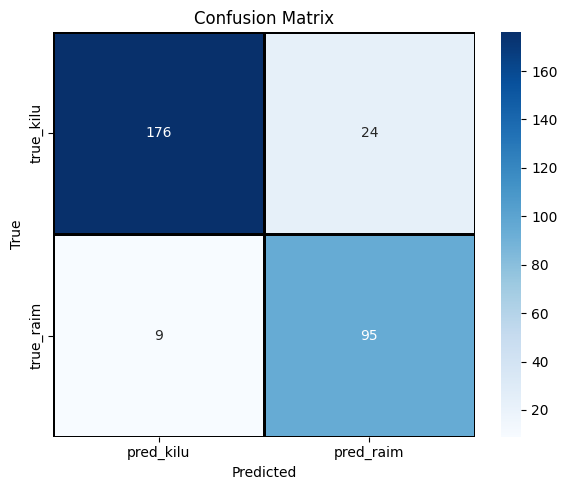

In [ ]:
classes = ["kilu", "raim"]

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["pred_kilu", "pred_raim"],
    yticklabels=["true_kilu", "true_raim"],
    cbar=True,
    linewidths=1,
    linecolor="black"
)

plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


# Let's see what the extracted fish look like

In [ ]:
def visualize_polygons_on_image(img_path):
    """
    Runs YOLO + SAM and draws polygon contours on the correctly rotated image.
    """

    MIN_AREA_THRESHOLD = 10000

    # ----------------------------------------
    # Load original (for display later)
    # ----------------------------------------
    orig_bgr = cv2.imread(str(img_path))
    orig_rgb = cv2.cvtColor(orig_bgr, cv2.COLOR_BGR2RGB)

    # ----------------------------------------
    # Rotate if needed (same rule used in extractor pipeline)
    # ----------------------------------------
    processed_rgb = rotate_if_vertical(orig_rgb)
    proc_h, proc_w = processed_rgb.shape[:2]

    # ----------------------------------------
    # YOLO prediction on rotated image
    # ----------------------------------------
    preds = yolo_predict_rotated(extraction_model, processed_rgb)

    # YOLO input shape (used for scaling)
    yolo_h, yolo_w = preds.boxes.orig_shape
    scale_x = proc_w / yolo_w
    scale_y = proc_h / yolo_h

    # ----------------------------------------
    # SAM on the same rotated image
    # ----------------------------------------
    extractor.set_image(processed_rgb)

    all_masks = []

    # ----------------------------------------
    # YOLO → SAM conversion loop
    # ----------------------------------------
    for (x1, y1, x2, y2) in preds.boxes.xyxy.cpu().numpy():

        # Scale YOLO → rotated image coordinates
        x1_o = int(x1 * scale_x)
        y1_o = int(y1 * scale_y)
        x2_o = int(x2 * scale_x)
        y2_o = int(y2 * scale_y)

        # Clip
        x1_o = max(0, min(proc_w - 1, x1_o))
        y1_o = max(0, min(proc_h - 1, y1_o))
        x2_o = max(0, min(proc_w - 1, x2_o))
        y2_o = max(0, min(proc_h - 1, y2_o))

        cx_o = (x1_o + x2_o) // 2
        cy_o = (y1_o + y2_o) // 2

        # Run SAM on rotated image
        masks, _, _ = extractor.predict(
            point_coords=np.array([[cx_o, cy_o]]),
            point_labels=np.array([1]),
            box=np.array([x1_o, y1_o, x2_o, y2_o]),
            multimask_output=False
        )

        mask = masks[0]
        if mask.sum() < MIN_AREA_THRESHOLD:
            continue

        all_masks.append(mask)

    # ----------------------------------------
    # Draw contours on rotated image
    # ----------------------------------------
    vis = processed_rgb.copy()
    vis_bgr = cv2.cvtColor(vis, cv2.COLOR_RGB2BGR)

    for mask in all_masks:
        mask_uint8 = (mask > 0).astype(np.uint8) * 255
        contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(vis_bgr, contours, -1, (52, 52, 235), thickness=3)

    # ----------------------------------------
    # Show visualization
    # ----------------------------------------
    plt.figure(figsize=(12, 10))
    plt.imshow(cv2.cvtColor(vis_bgr, cv2.COLOR_BGR2RGB))
    plt.title(f"Polygon boundaries – {img_path.name}")
    plt.axis("off")
    plt.show()


Found 4 test images (kilu + raim).

--- Visualizing: Traal 1 kilu.jpg ---


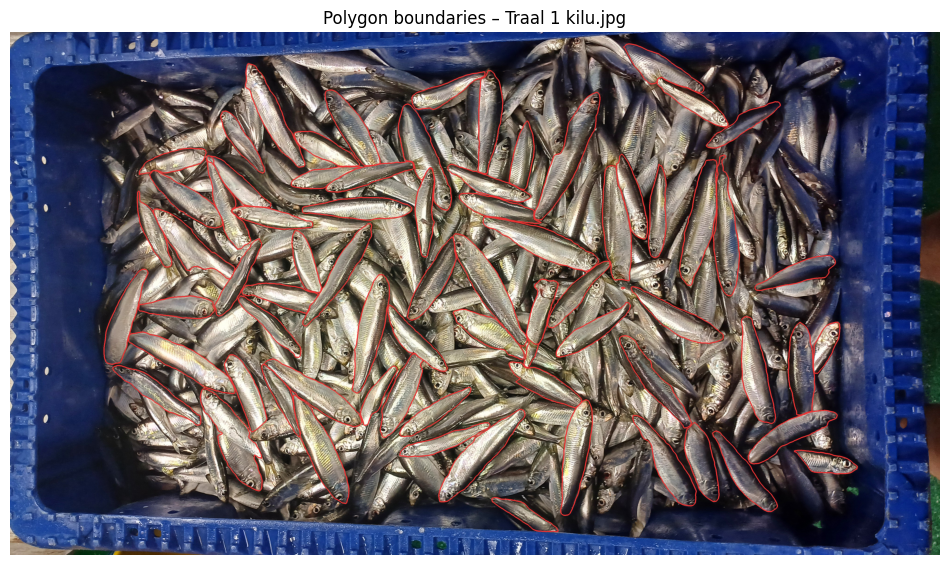


--- Visualizing: Traal 10 kilu.jpg ---


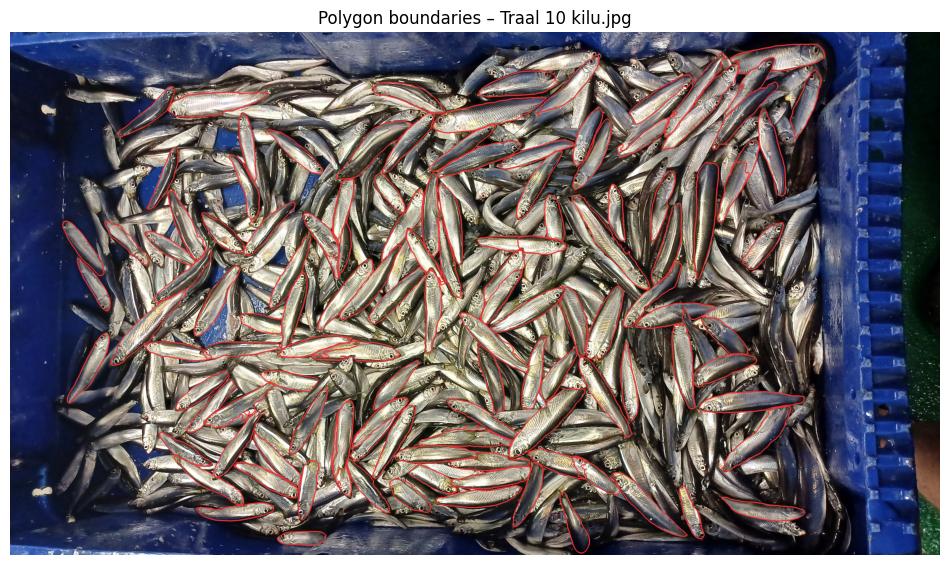


--- Visualizing: Traal 2 raim.jpg ---


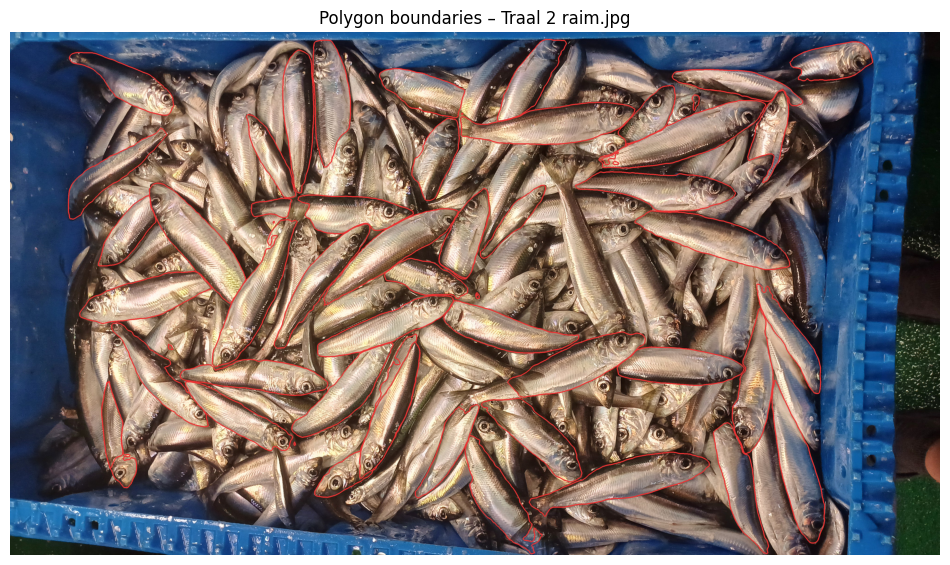


--- Visualizing: Traal 5 raim.jpg ---


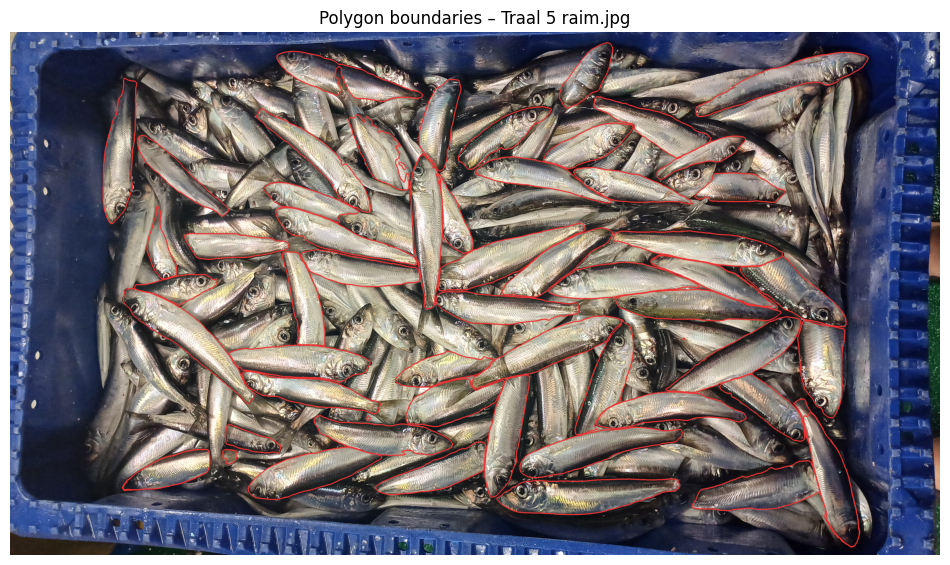

In [ ]:
TEST_CONTAINERS = PROJECT_ROOT / "data/fishfoto_data_raw/kilu_raim_train_test_split/test"

test_imgs = []
for class_name in ["kilu", "raim"]:
    folder = TEST_CONTAINERS / class_name
    test_imgs += sorted(folder.glob("*.jpg")) + sorted(folder.glob("*.png"))

print(f"Found {len(test_imgs)} test images (kilu + raim).")

# Visualize polygons on each test image
for img_path in test_imgs:
    print(f"\n--- Visualizing: {img_path.name} ---")
    visualize_polygons_on_image(img_path)
